In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
fix_df = pd.read_excel('data/BAD_ADDRESS_FIX.xlsx').drop_duplicates('id').set_index('id')
name2sub_area = pd.read_csv('data/name2sub_area.csv', index_col='sub_area')

In [4]:
# train_df.update(fix_df, overwrite=True)
# test_df.update(fix_df, overwrite=True)
del fix_df

In [5]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

In [6]:
train_macro_df = train_df.merge(macro_df, on='timestamp', how='left')
test_macro_df = test_df.merge(macro_df, on='timestamp', how='left' )

In [7]:
train_macro_df['sub_area'] = train_macro_df['sub_area'].map(name2sub_area['OKRUG'].to_dict())
test_macro_df['sub_area'] = test_macro_df['sub_area'].map(name2sub_area['OKRUG'].to_dict())
del name2sub_area

In [8]:
def encode(df):
    # Timestamp encoding
    df['timestamp_year'] = df['timestamp'].dt.year
    df['timestamp_month'] = df['timestamp'].dt.month
    df['timestamp_day'] = df['timestamp'].dt.day
    df.drop(labels='timestamp', axis=1, inplace=True)

    # Categorical columns encoding
    df['product_type'] = df['product_type'].map({'Investment': 0, 'OwnerOccupier':1})

    # Ecology
    eco_map = {'no data': np.NaN, # 0?
               'poor': 1,
               'satisfactory': 2,
               'good': 3,
               'excellent': 4,}
    df['ecology'] = df['ecology'].map(eco_map)

    # Sub_area 
    one_hot = pd.get_dummies(df['sub_area'])
    df.drop('sub_area', axis=1, inplace=True)
    df = df.join(one_hot)

    # yes/no
    cat_columns = df.select_dtypes(include='object').columns
    df[cat_columns] = df[cat_columns].applymap(lambda x: 0 if x=='no' else 1)
    
    return df

In [9]:
train_macro_df = encode(train_macro_df)
test_macro_df = encode(test_macro_df)
target = train_macro_df.pop('price_doc')

In [10]:
X, y = train_macro_df.values, target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((24376, 402), (24376,))

In [18]:
params = {'n_estimators': 800,
          'booster': 'gbtree',
          'max_depth': 5,
          'eval_metric': 'mae',
          'learning_rate': 0.05,
          'reg_alpha': 100,
          'min_child_weight': 0,
          # 'subsample': 0.8,
          # 'colsample_bytree': 0.79,
          'seed': 42,
          'nthread': -1
          }

model = XGBRegressor(objective='reg:squarederror', **params)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])


[0]	validation_0-mae:6790146.50000	validation_1-mae:6678436.50000
[1]	validation_0-mae:6452930.00000	validation_1-mae:6346968.50000
[2]	validation_0-mae:6137535.50000	validation_1-mae:6035577.50000
[3]	validation_0-mae:5845554.50000	validation_1-mae:5747461.00000
[4]	validation_0-mae:5577387.50000	validation_1-mae:5483481.00000
[5]	validation_0-mae:5326543.00000	validation_1-mae:5236714.50000
[6]	validation_0-mae:5092250.00000	validation_1-mae:5008017.00000
[7]	validation_0-mae:4873079.00000	validation_1-mae:4792160.50000
[8]	validation_0-mae:4668372.50000	validation_1-mae:4591549.00000
[9]	validation_0-mae:4476145.00000	validation_1-mae:4402952.50000
[10]	validation_0-mae:4296237.00000	validation_1-mae:4226161.50000
[11]	validation_0-mae:4126594.75000	validation_1-mae:4060310.25000
[12]	validation_0-mae:3966527.75000	validation_1-mae:3903202.75000
[13]	validation_0-mae:3816040.75000	validation_1-mae:3755881.50000
[14]	validation_0-mae:3673593.75000	validation_1-mae:3616661.25000
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=5,
             min_child_weight=0, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=100, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [19]:
y_pred_val = np.abs(model.predict(X_val))
y_pred_train = np.abs(model.predict(X_train))
np.sqrt(mean_squared_log_error(y_train, y_pred_train)), np.sqrt(mean_squared_log_error(y_val, y_pred_val))

(0.3860406686767359, 0.4625025117286844)

<BarContainer object of 402 artists>

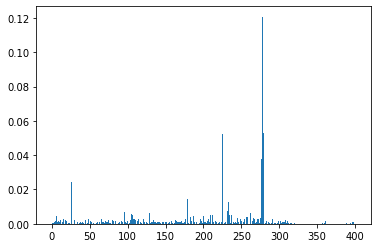

In [21]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

In [13]:
global X_test
X_test = test_macro_df.values

In [14]:
def create_submission(model):
    submission = pd.read_csv('data/sample_submission.csv')
    pred = model.predict(X_test)
    if len(pred[pred < 0]):
        print('WARNING: NEGATIVE PREDICTIONS')
        pred = np.abs(pred)
    submission['price_doc'] = pred
    submission.to_csv('submission.csv', index=False)

In [15]:
create_submission(model)

In [16]:
!kaggle competitions submit -c sberbank-russian-housing-market -f submission.csv -m "naive XGBRegressor with OKRUG"

100%|████████████████████████████████████████| 121k/121k [00:02<00:00, 60.5kB/s]
Successfully submitted to Sberbank Russian Housing Market

In [17]:
!kaggle competitions submissions -c sberbank-russian-housing-market

fileName        date                 description                                   status    publicScore  privateScore  
--------------  -------------------  --------------------------------------------  --------  -----------  ------------  
submission.csv  2021-11-12 18:19:49  naive XGBRegressor with OKRUG                 complete  0.33627      0.34593       
submission.csv  2021-11-12 18:07:03  naive XGBRegressor with OKRUG                 complete  0.33615      0.35028       
submission.csv  2021-11-12 18:02:19  naive XGBRegressor with OKRUG                 complete  0.32857      0.33310       
submission.csv  2021-11-12 17:31:16  naive XGBRegressor with 'Tverskoe issue' fix  complete  0.33586      0.33922       
submission.csv  2021-11-12 17:30:10  naive XGBRegressor with 'Tverskoe issue' fix  complete  0.32494      0.32895       
submission.csv  2021-11-12 16:14:31  naive XGBRegressor with raw macro.csv         complete  0.32494      0.32895       
submission.csv  2021-11-12 16:00

In [ ]:
def get_place(my_score):
    df = pd.read_csv('publicleaderboard.csv')
    scores = df['Score'].values
    scores = np.append(scores, my_score)
    scores = np.sort(scores)
    print(f'{np.where(scores == my_score)[0][0]} / {len(scores)}')

In [ ]:
my_score = 0.32494
get_place(my_score)

1936 / 3266
